In [1]:
import warnings


import staircase as sc
from imports import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import hotstepper as hs
from hotstepper.utilities import get_epoch_start,date_to_float_bulk
from hotstepper import Bases, Basis

import hotstepper.samples as samples
warnings.filterwarnings("ignore")

In [2]:
hs.utilities.is_date_time(pd.Timestamp(2020))

True

In [3]:
df = pd.read_csv(r"..//..//data/vessel_queue.csv", parse_dates=['enter', 'leave'], dayfirst=True)
vsteps = samples.vessel_queue_sample()
queue = sc.Stairs(use_dates=True).layer(df.enter,df.leave)
#queue = queue.clip(upper=pd.Timestamp(2020,3,1))

In [4]:
%%timeit -r 3 -n 3
vsteps = hs.Steps(use_datetime=True).add_direct(df.enter,df.leave)

10.5 ms ± 1.07 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [5]:
%%timeit -r 3 -n 3
queue = sc.Stairs(use_dates=True).layer(df.enter,df.leave)

10.2 ms ± 1.37 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


<AxesSubplot:>

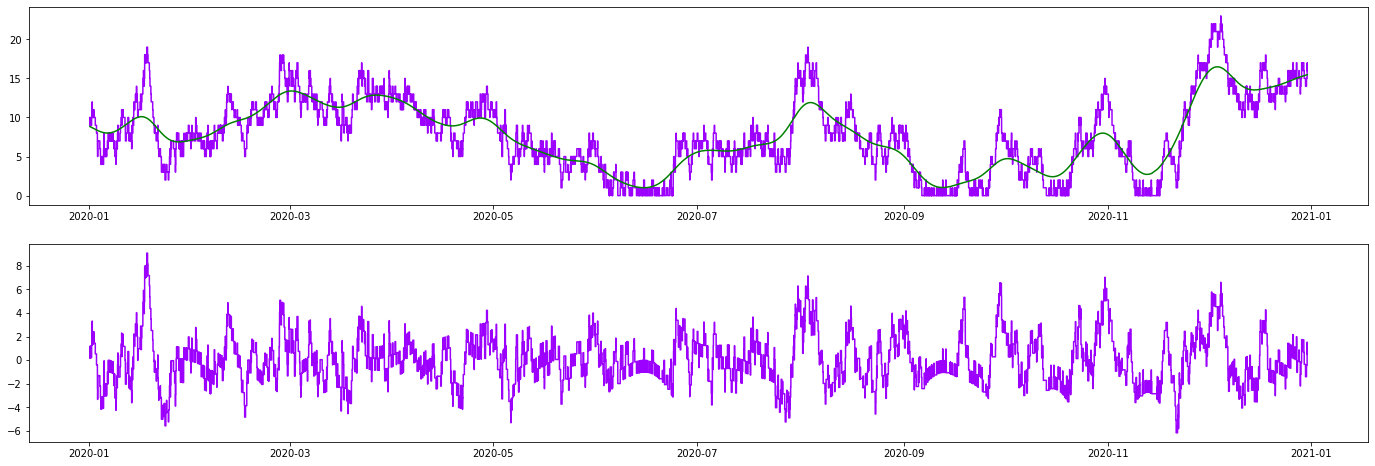

In [6]:
#p = np.arange(pd.Timestamp(2020,1,1),pd.Timestamp(2020,3,1),pd.Timedelta(hours=1)).astype(pd.Timestamp)

fig,(ax,ax2) = plt.subplots(nrows=2,figsize=(24,8))

#vsteps = vsteps.clip(ubound=pd.Timestamp(2020,3,1))
vsteps_smooth = vsteps.copy()
vsteps_smooth.rebase(hs.Basis(hs.Bases.logit))
#vsteps.rebase()
vsteps.plot(ax=ax)
vsteps_smooth.smooth_plot(ax=ax,color='g')

delta_steps = vsteps - vsteps_smooth
delta_steps.plot(ax=ax2)


<AxesSubplot:title={'center':'Step Values Histogram'}, xlabel='Steps Range'>

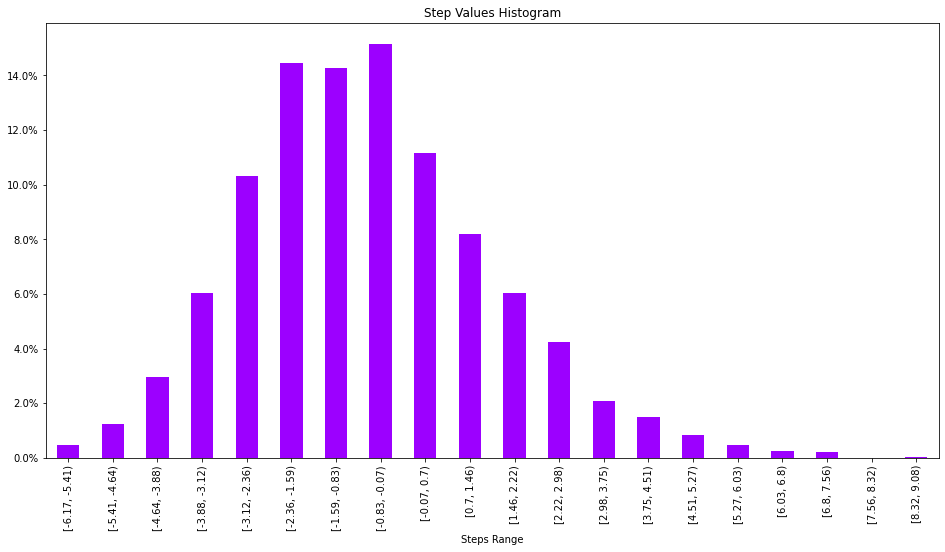

In [7]:
delta_steps.histogram_plot()

<AxesSubplot:>

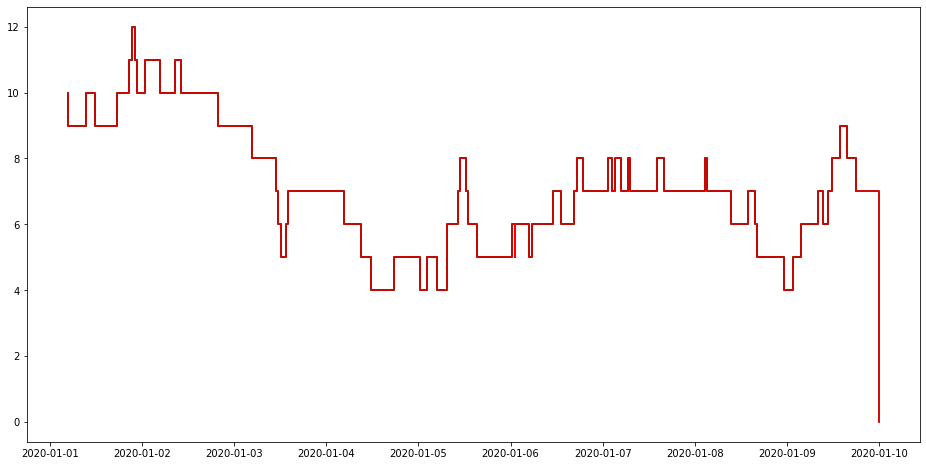

In [8]:
clip_step_end = hs.Step(end=pd.Timestamp(2020,1,10))
steps_end = hs.Steps(True).add_direct([None],[pd.Timestamp(2020,1,10)])
clip_step_start = hs.Step(start=pd.Timestamp(2020,5,1))

ax = vsteps.clip(ubound=pd.Timestamp(2020,1,10)).plot(color='g')
(vsteps*clip_step_end).plot(ax=ax,color='black')
(vsteps*steps_end).plot(ax=ax,color='r')


<AxesSubplot:>

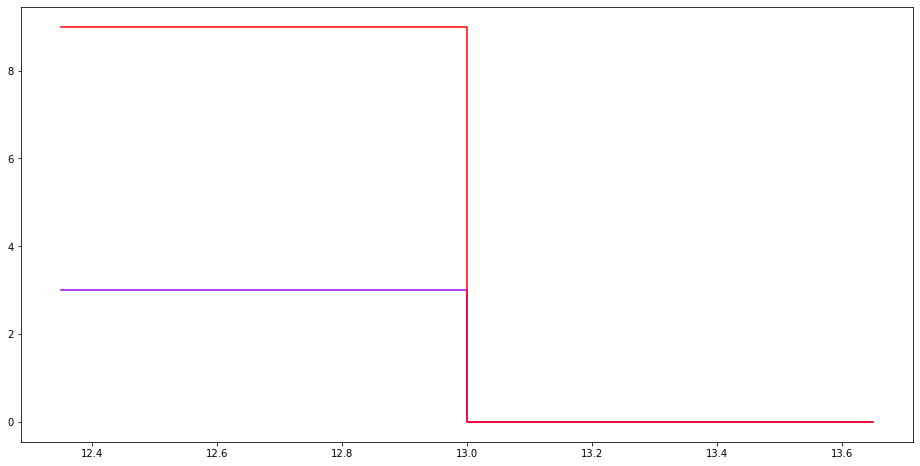

In [9]:
s3 = hs.Step(end=13,weight=3)
#s3.step([get_epoch_start(False),14])
ax = s3.plot(method='function')
(s3*s3).plot(ax=ax,color='r')

[<AxesSubplot:>,
 <AxesSubplot:title={'center':'Step Values Empirical Distribution'}, xlabel='Steps Range'>,
 <AxesSubplot:>,
 <AxesSubplot:title={'center':'Step Values Histogram'}, xlabel='Steps Range'>,

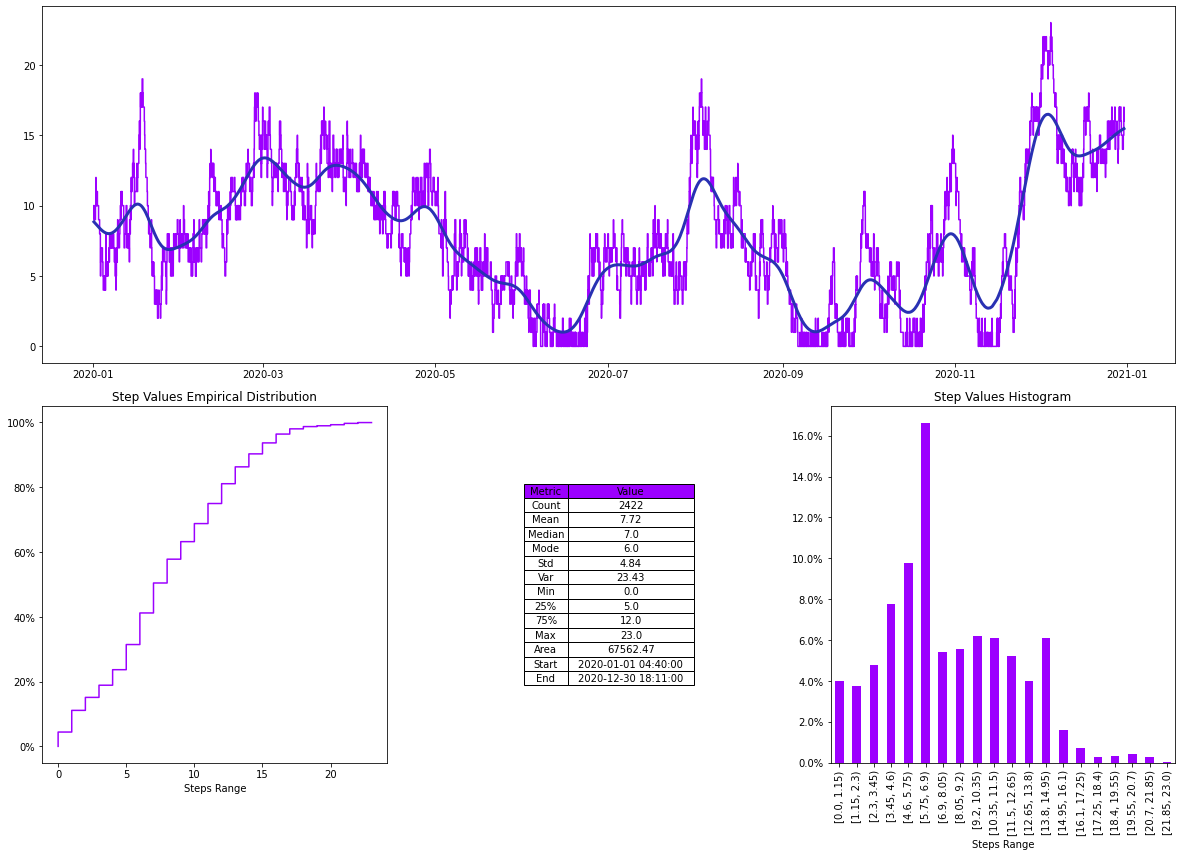

In [10]:
vsteps.summary()

<AxesSubplot:>

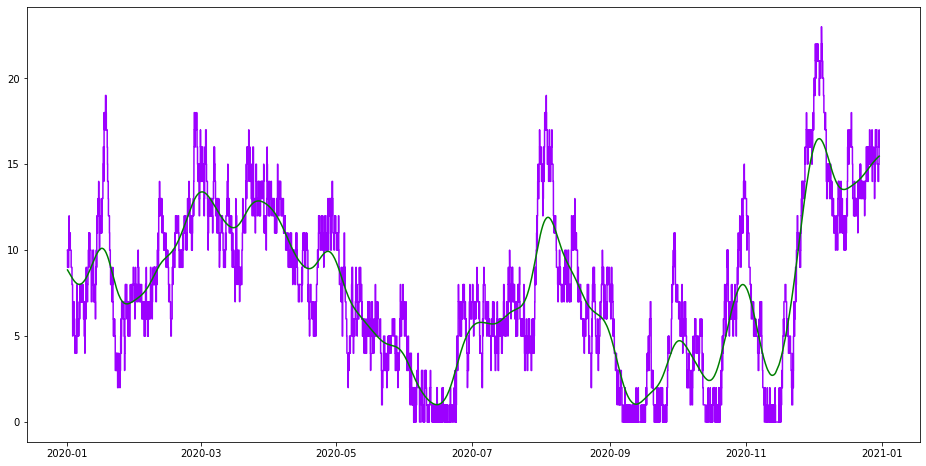

In [11]:
ax = vsteps.plot()
vsteps.smooth_plot(ax=ax,color='g')

In [12]:
p = np.arange(vsteps.first(),vsteps.last(),pd.Timedelta(minutes=10)).astype(pd.Timestamp)
p3 = np.arange(vsteps.first().to_numpy(), vsteps.last().to_numpy(),np.timedelta64(10, 'm'),dtype='datetime64[ns]')
p2 = np.arange(vsteps.first(),vsteps.last(),pd.Timedelta(minutes=10)).astype(float)

In [13]:
%%timeit -r 5 -n 5
vsteps.fast_step(p)

55 ms ± 4.06 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [14]:
%%timeit -r 5 -n 5
queue(p)

305 ms ± 18.8 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


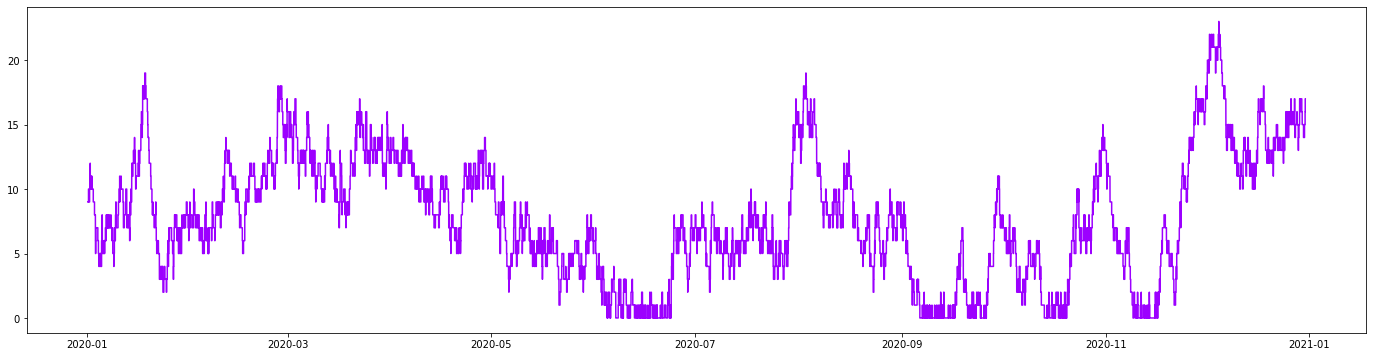

In [15]:
fig,ax = plt.subplots(figsize=(24,6))

ax.step(p,vsteps[p])

In [16]:
origin = pd.to_datetime("1970-1-1")

d = np.datetime64('1980-01-01T10:12')

fd = (d - origin.tz_localize(None)) / pd.Timedelta(1, "s")
fd

315569520.0

In [17]:
fd*pd.Timedelta(1, "s") + origin

Timestamp('1980-01-01 10:12:00')

In [18]:
vsteps[vsteps.first():vsteps.last():pd.Timedelta(minutes=10)]

array([ 9.,  9.,  9., ..., 16., 17., 17.])

In [19]:
vsteps.fast_step(p,side='left')

array([10.,  9.,  9., ..., 16., 17., 17.])

In [20]:
import datetime
#print(get_ts(datetime.datetime(1980,1,1,10,12)),'\n',get_ts(pd.Timestamp(1980,1,1,10,12)))
print(hs.utilities.date_to_float_bulk(datetime.datetime(1980,1,1,10,12)),'\n',hs.utilities.date_to_float_bulk(pd.Timestamp(1980,1,1,10,12)))

print(hs.utilities.date_to_float_bulk(np.datetime64('nat')),'\n',hs.utilities.date_to_float_bulk(pd.Timestamp(1980,1,1,10,12)))


315569520.0 
 315569520.0
nan 
 315569520.0


<AxesSubplot:>

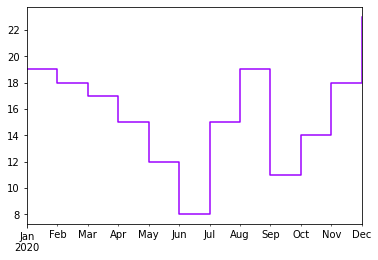

In [21]:
vs = vsteps.series().resample('1M',label='right',closed='left').max()
vs.plot(drawstyle='steps-post')

In [22]:
s = vs.index.values.copy()
e = vs.index.values.copy()
v = vs.values

In [23]:
v

array([19., 18., 17., 15., 12.,  8., 15., 19., 11., 14., 18., 23.])

In [24]:
#s[0] = None
#np.datetime64('2020-01-01')
#s = np.insert(s,0,None)
#s = np.append(s,np.datetime64('2020-12-31'))

#v = np.insert(v,0,s[0])
#v = np.append(v,0)

#v[0] = v[1]

In [25]:
v

array([19., 18., 17., 15., 12.,  8., 15., 19., 11., 14., 18., 23.])

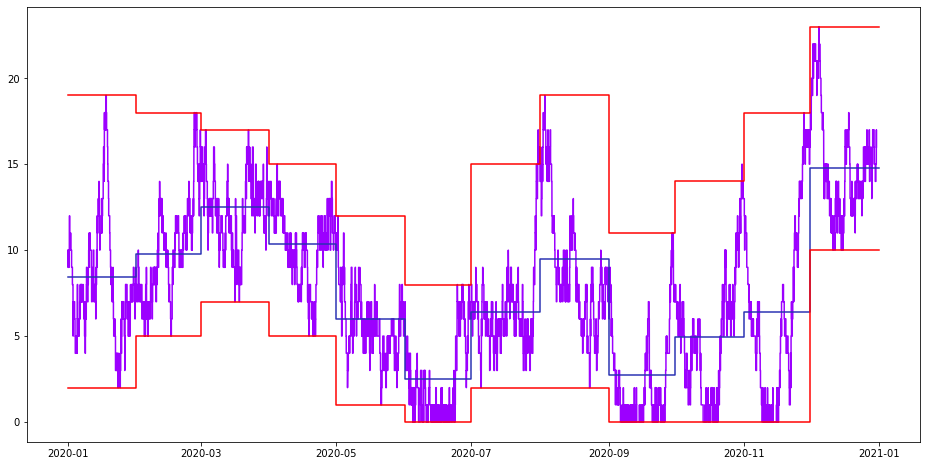

In [26]:
vs_min = vsteps.series().resample('1M',label='right',closed='left').min()
vs_max = vsteps.series().resample('1M',label='right',closed='left').max()
vs_mean = vsteps.series().resample('1M',label='right',closed='left').mean()

p= pd.date_range('2020-01-01','2021-02-01' , freq='1M')-pd.offsets.MonthBegin(1)

vs_resample_min = hs.Steps.read_array(start=vs_min.index.values,weight=vs_min.values,convert_delta=True)
vs_resample_max = hs.Steps.read_array(start=vs_max.index.values,weight=vs_max.values,convert_delta=True)
vs_resample_mean = hs.Steps.read_array(start=vs_mean.index.values,weight=vs_mean.values,convert_delta=True)

ax = vsteps.plot()
ax.step(p,vs_resample_mean.fast_step(p),where='post')
ax.step(p,vs_resample_min.fast_step(p),where='post',color='r')
ax.step(p,vs_resample_max.fast_step(p),where='post',color='r')

In [27]:
vs_resample_mean.last()

Timestamp('2020-11-30 00:00:00')

In [28]:
vjan = vsteps.clip(ubound=pd.Timestamp(2020,2,1))
vjan.mean()

8.18813356512316